0.3093574619173062
0.3090138586645287
0.3088993242469362
0.3088993242469362
0.30924292749971366
0.3099301340052686
0.310502806093231
0.3106173405108235
0.31096094376360095
0.3115336158515634
0.31210628793952583
0.31279349444508076
0.31336616653304317
0.31370976978582066
0.31359523536822814
0.3143969762913756
0.31428244187378307
0.3143969762913756
0.3140533730385981
0.3143969762913756
([0.3093574619173062, 0.3090138586645287, 0.3088993242469362, 0.3088993242469362, 0.30924292749971366, 0.3099301340052686, 0.310502806093231, 0.3106173405108235, 0.31096094376360095, 0.3115336158515634, 0.31210628793952583, 0.31279349444508076, 0.31336616653304317, 0.31370976978582066, 0.31359523536822814, 0.3143969762913756, 0.31428244187378307, 0.3143969762913756, 0.3140533730385981, 0.3143969762913756], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
--- 277.5837912559509 seconds ---


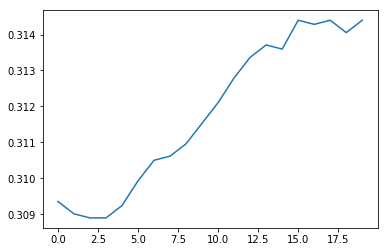

In [6]:
import numpy as np
from sklearn.metrics import pairwise_distances
import time
from util.word2vec_as_MF import Word2vecMF
from util.functions import *
from util.visualize import *
start_time = time.time()
def nearest_neighbors(model, W, word, exclude=[], metric="cosine"):
    #print(model.W.T.shape, 'model.W.T.shape')
    #print(word.reshape(1, -1).shape, 'word.reshape(1, -1)')
    D = word @ W
    #print(D.shape, 'D.shape')
    D[np.array(exclude)]=D.min()
    '''for w in exclude:
        D[w] = D.min()'''
    #print(exclude)
    #print(model.inv_vocab[D.argmin(axis=0)[0]])
    return D.argmax(axis=0)
        
def analogy_score(from_folder, index, evalX):
    from_folder='enwik-200/'+from_folder
    
    model =  Word2vecMF()
    model.load_vocab(from_folder+'/vocab.txt')
    vocab = model.vocab    
    _, model.W = model.load_CW(from_folder, index)
    normInv = np.array([1./n if n else 0. for n in np.linalg.norm(model.W, axis=0)])
    #print(np.count_nonzero(normInv)/normInv.shape[0])
    #W = model.W*normInv
    W=model.W = model.W*normInv

    predict = model.W.T[evalX[:,1]]-model.W.T[evalX[:,0]]+model.W.T[evalX[:,2]] # (:, dim)
    
    closest = np.array([nearest_neighbors(model, W, p, exclude=[evalX[i,0], evalX[i,1], evalX[i,2]])
                        for i,p in enumerate(predict)])
    
    closest = closest.reshape(-1,)
    #print(model.vocab[evalX[:,:]])
    #eturn predict, (predict == evalX[:,3]).mean(), predict.shape, evalX[:,3].shape
    #print(evalX[:,3].shape)
    #print(closest.shape)
    #print((closest == evalX[:,3]))
    score =(closest == evalX[:,3]).mean()
    print(score)
    return score

def analogy_dict(from_folder,MAX_ITER=100, plot_corrs=False):
    model =  Word2vecMF()
    model.load_vocab('enwik-200/'+from_folder+'/vocab.txt')
    vocab = model.vocab
    #model.C, model.W = model.load_CW('enwik-200/'+from_folder, 20)
    X = []
    with open('benchmark/syntactic-words.txt') as file:
        count =0
        for line in file:
            tokens = line.split()
            tokens = [tk.lower() for tk in tokens]
            if tokens[0] in vocab and tokens[1] in vocab and tokens[2] in vocab and tokens[3] in vocab:
                #print(tokens[0], tokens[1], tokens[2], tokens[3])
                count=count+1
                X.append([vocab[tokens[0]], vocab[tokens[1]], vocab[tokens[2]], vocab[tokens[3]]])
                #word = model.W.T[vocab[tokens[1]]]-model.W.T[vocab[tokens[0]]]+model.W.T[vocab[tokens[2]]]
                #print(model.inv_vocab[nearest_neighbors(model, word, exclude=[vocab[tokens[0]], vocab[tokens[1]], vocab[tokens[2]], vocab[tokens[3]]])])
            #if count > 50:break
        X=np.array(X)
        #print(X.shape)
        
    filelist = glob.glob('enwik-200/'+from_folder+'/W*.npz')
    steps = sorted([int(file.split('/')[-1][1:-4]) for file in filelist])
    steps = [step for step in steps if step<MAX_ITER]
    
    analogy= [analogy_score(from_folder=datapath, index=step, evalX=X) for step in steps]
    #print(steps, analogy)
    plt.plot(steps, analogy)
    
    return analogy, steps 
  

label_list= {'BFGDiter_fromenwik9-sub0.000100SPPMI5_dim100_step2e-07_0.0': 'BFGD 1.0-8'}
for datapath in label_list.keys():
    print(analogy_dict(datapath, MAX_ITER=20))
print("--- %s seconds ---" % (time.time() - start_time))
